Implementación del paper "Image Classification for Dogs and Cats" empleando data augmentation de "The Effectiveness of Data Augmentation in Image Classification using Deep Learning"

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout, ReLU, MaxPool2D, AvgPool2D, Input, LeakyReLU, concatenate, ZeroPadding2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tqdm import tqdm
from random import choice
from tensorflow.keras.models import Model
from keras.layers import add
%matplotlib inline
tf.random.set_seed(0)
import os
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/Pucp/Ciclo 22-1/TAC/TA/Code'

/content/drive/MyDrive/Pucp/Ciclo 22-1/TAC/TA/Code


In [4]:
# %cd '/content/drive/MyDrive/TAC/TA/Code'

In [5]:
# Definición de variables globales
IMAGE_WIDTH=350
IMAGE_HEIGHT=350
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Leer imagenes

In [6]:
# Rutas de archivos
path_train = "train1"
path_test = "test1"
batch_size = 15
class_names = ["dog", "cat"]

In [8]:
# Almacenando nombres train de archivos en df
filenames = os.listdir(path_train)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.head()

,filename,category
0,dog.9136.jpg,1
1,dog.9101.jpg,1
2,dog.9133.jpg,1
3,dog.9128.jpg,1
4,dog.91.jpg,1


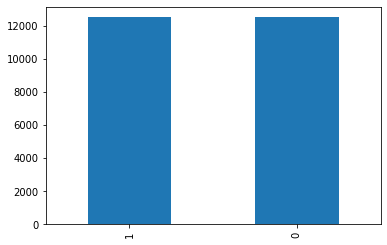

In [9]:
# Visualizando cantidad por categoria
df['category'].value_counts().plot.bar()

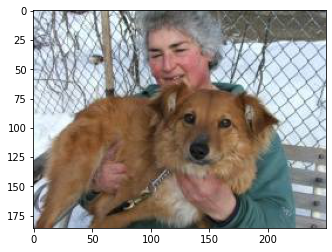

In [10]:
# Vizualisando imagen aleatoria del df
sample = random.choice(filenames)
image = load_img("train1/"+sample)
plt.imshow(image)

In [11]:
# Separando data de train y validate
train_df, validate_df = train_test_split(df, test_size=0.2)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

# De acuerdo con el paper, solo se toma 2000 imagenes para train y 500 para validate
train_df = train_df.sample(n=2000).reset_index()
validate_df = validate_df.sample(n=500).reset_index()

# Cast de columna
train_df['category'] = train_df['category'].astype(str)
validate_df['category'] = validate_df['category'].astype(str)

# Cantidad total por train y validate
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [12]:
# Data augmentation de acuerdo al paper
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.4,
        rotation_range=50,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# Lectura de imagenes train de acuerdo a la cantidad señalada
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    path_train, 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 2000 validated image filenames belonging to 2 classes.


In [13]:
# Lectura de imagenes validate de acuerdo a la cantidad señalada
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    path_train, 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 500 validated image filenames belonging to 2 classes.


In [14]:
def plot_random_image(path, list_of_images_paths):
  #Seleccionar aleatoriamente una imagen
  random_image_path = choice(list_of_images_paths)

  #Cargar la imagen
  image = Image.open(path + "/" + random_image_path).convert("RGBA")

  #Mostrar la imagen
  plt.imshow(image)
  plt.axis("off")

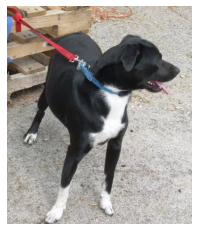

In [15]:
# Vizualisando imagen aleatoria del train_generator
plot_random_image(path_train, train_generator.filenames)

# Crear modelo

In [16]:
def create_model():
    K.clear_session()
    in_layer = Input(shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS))
    conv_1 = Conv2D(96, (3, 3), activation='relu', padding='same', kernel_initializer= 'glorot_normal')(in_layer)
    bn_1 = BatchNormalization()(conv_1)
    mp_1 = MaxPool2D((2, 2))(bn_1)
    do_1 = Dropout(0.25)(mp_1)

    conv_2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer= 'glorot_normal')(do_1)
    bn_2 = BatchNormalization()(conv_2)
    mp_2 = MaxPool2D((2, 2))(bn_2)
    do_2 = Dropout(0.25)(mp_2)

    conv_3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer= 'glorot_normal')(do_2)
    bn_3 = BatchNormalization()(conv_3)
    mp_3 = MaxPool2D((2, 2))(bn_3)
    do_3 = Dropout(0.25)(mp_3)
    
    flatten = Flatten()(do_3)
    dense_1 = Dense(512,activation='relu', kernel_initializer= 'glorot_normal')(flatten)
    bn_4 = BatchNormalization()(dense_1)
    do_4 = Dropout(0.5)(bn_4)
    out_layer = Dense(1,activation='sigmoid')(do_4)

    model = Model(inputs=in_layer, outputs=out_layer)
    return model

In [17]:
lr = 0.0001
model = create_model()
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 350, 350, 96)      2688      
                                                                 
 batch_normalization (BatchN  (None, 350, 350, 96)     384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 175, 175, 96)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 175, 175, 96)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 175, 175, 64)      55360 

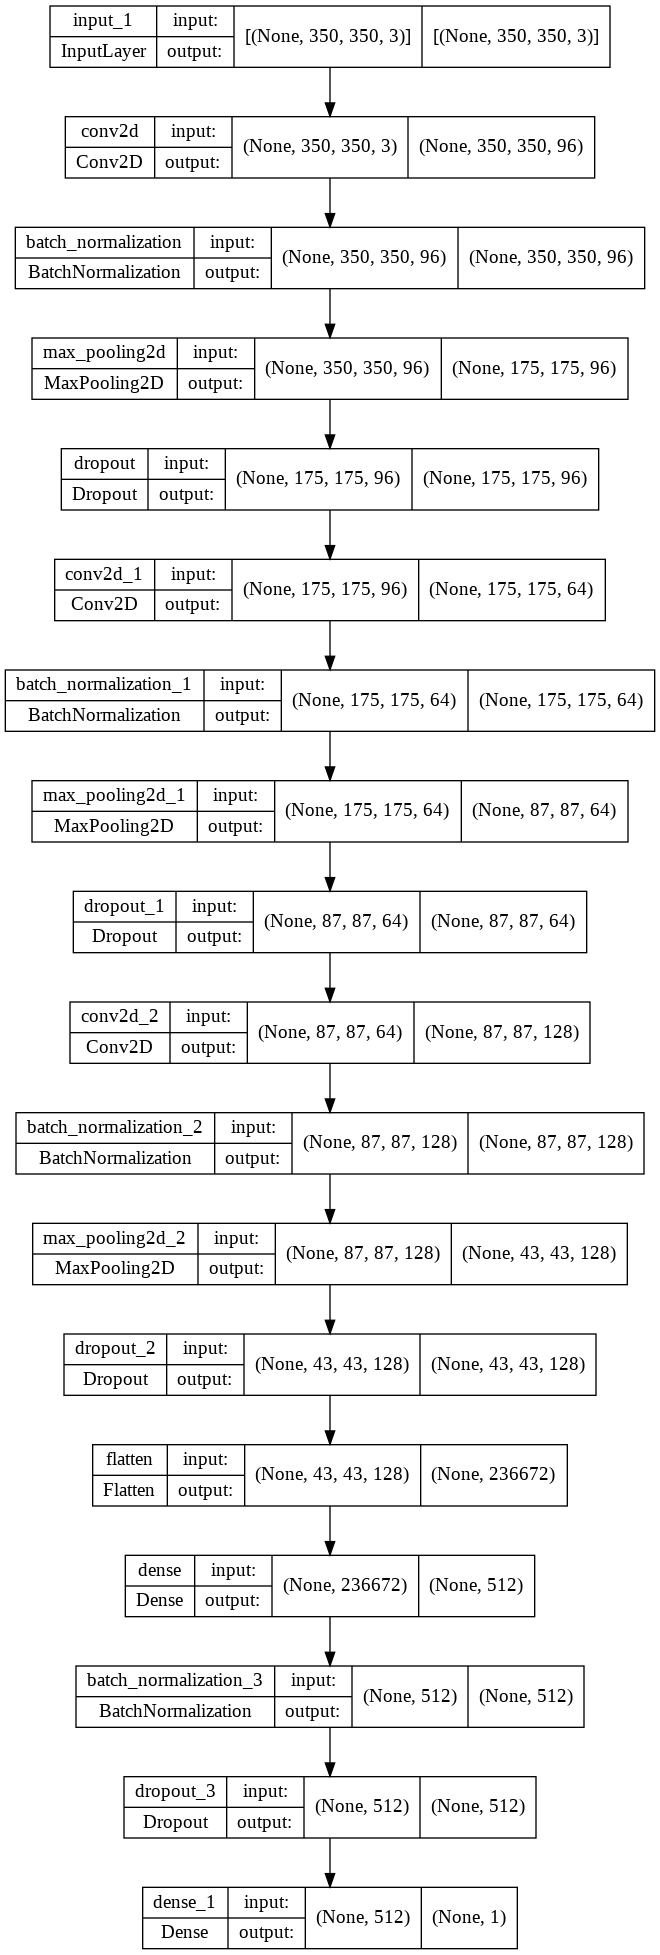

In [19]:
tf.keras.utils.plot_model(model,show_shapes=True)

# Entrenar modelo

In [20]:
def show_results(log):
  loss = log.history['loss']
  acc = log.history['accuracy']

  val_loss = log.history['val_loss']
  val_acc = log.history['val_accuracy']
  
  fig, axes = plt.subplots(1, 2, figsize=(14,4))
  ax1, ax2 = axes

  ax1.plot(loss, label='train')
  ax1.plot(val_loss, label='test')
  
  ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
  
  ax2.plot(acc, label='train')
  ax2.plot(val_acc, label='test')
  
  ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
  
  for ax in axes: ax.legend()

In [21]:
# Entrando el modelo con 20 epocas
log = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size
)

Epoch 1/20
133/133 [==============================] - 1188s 9s/step - loss: 1.0780 - accuracy: 0.5154 - val_loss: 0.8379 - val_accuracy: 0.5394
Epoch 2/20
133/133 [==============================] - 70s 522ms/step - loss: 0.8549 - accuracy: 0.5305 - val_loss: 0.7084 - val_accuracy: 0.5495
Epoch 3/20
133/133 [==============================] - 70s 528ms/step - loss: 0.7927 - accuracy: 0.5446 - val_loss: 0.9897 - val_accuracy: 0.4646
Epoch 4/20
133/133 [==============================] - 70s 526ms/step - loss: 0.7548 - accuracy: 0.5587 - val_loss: 0.8986 - val_accuracy: 0.5333
Epoch 5/20
133/133 [==============================] - 71s 530ms/step - loss: 0.7257 - accuracy: 0.5627 - val_loss: 0.7712 - val_accuracy: 0.5535
Epoch 6/20
133/133 [==============================] - 70s 527ms/step - loss: 0.7124 - accuracy: 0.5637 - val_loss: 0.6424 - val_accuracy: 0.6303
Epoch 7/20
133/133 [==============================] - 72s 539ms/step - loss: 0.6680 - accuracy: 0.6212 - val_loss: 1.0668 - val_acc

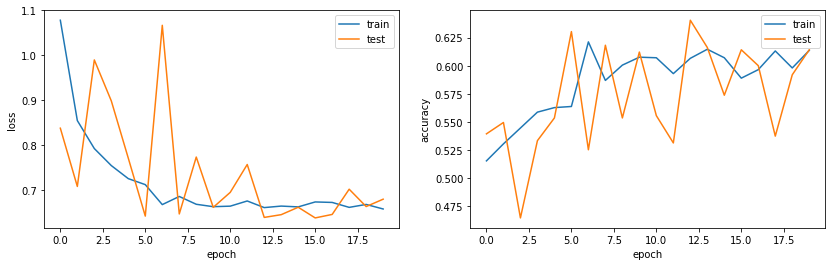

In [22]:
show_results(log)

In [23]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Test: accuracy = 0.610101  ;  loss = 0.682615 


# Probando modelo

In [24]:
def get_class(path, random_image_path, labels_dict, final_model):
  #Cargar la imagen del path
  img = Image.open(path + "/" + random_image_path).convert("RGB")
  
  #Mostrar la imagen
  plt.imshow(img)
  plt.axis('off')
  
  #Cambiar el tamaño de la imagen
  img_resized = img.resize(IMAGE_SIZE)

  #Cambiar a formato numpy
  x = np.asarray(img_resized, np.float32)
  x = x[None] #(224, 224, 3) -> (1, 224, 224, 3)
  
  #Obtener la predicción
  y = final_model.predict(x)
  
  #Decodificar la predicción
  pred = "cat" if y[0][0] < 0.5 else "dog"
  
  real = random_image_path.split(".", 1)[0]
  
  plt.title(f"Real value = {real} - Model prediction = {pred}")
  plt.show()

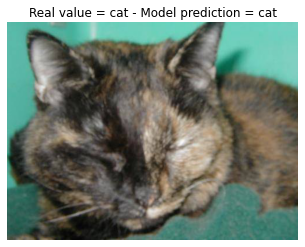

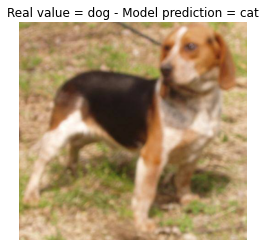

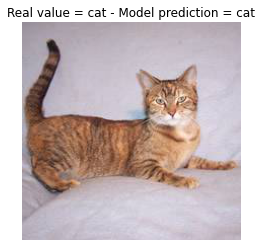

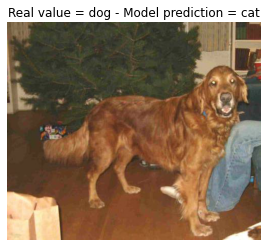

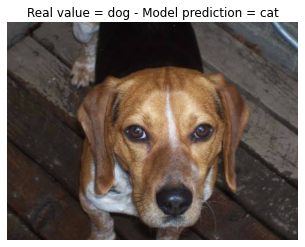

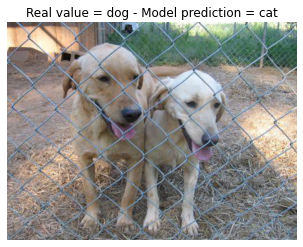

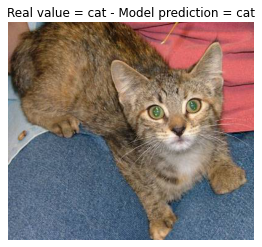

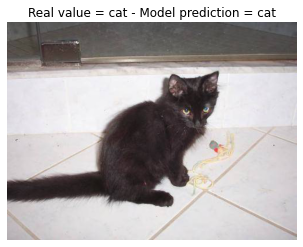

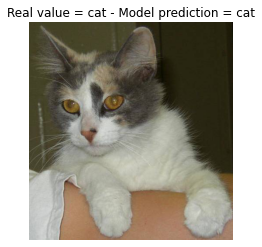

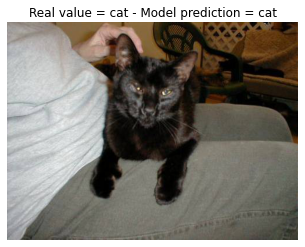

In [25]:
# Visualizando prediciones en validate
labels_dict = {k: i for i, k in validation_generator.class_indices.items()}
number_of_images_to_test = 10

for _ in range(number_of_images_to_test):
  random_image_path = choice(validation_generator.filenames)
  
  get_class(path_train, random_image_path, labels_dict, model)

# Aplicando modelo

In [26]:
# Almacenando nombres test de archivos en test_df
test_filenames = os.listdir("test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [27]:
# Leyendo imagenes en test_generator
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "test1", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=IMAGE_SIZE,
    shuffle=False
)

Found 12500 validated image filenames.


In [28]:
# Prediciendo las imagenes de test
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
threshold = 0.5
test_df['category'] = np.where(predict > threshold, 1,0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


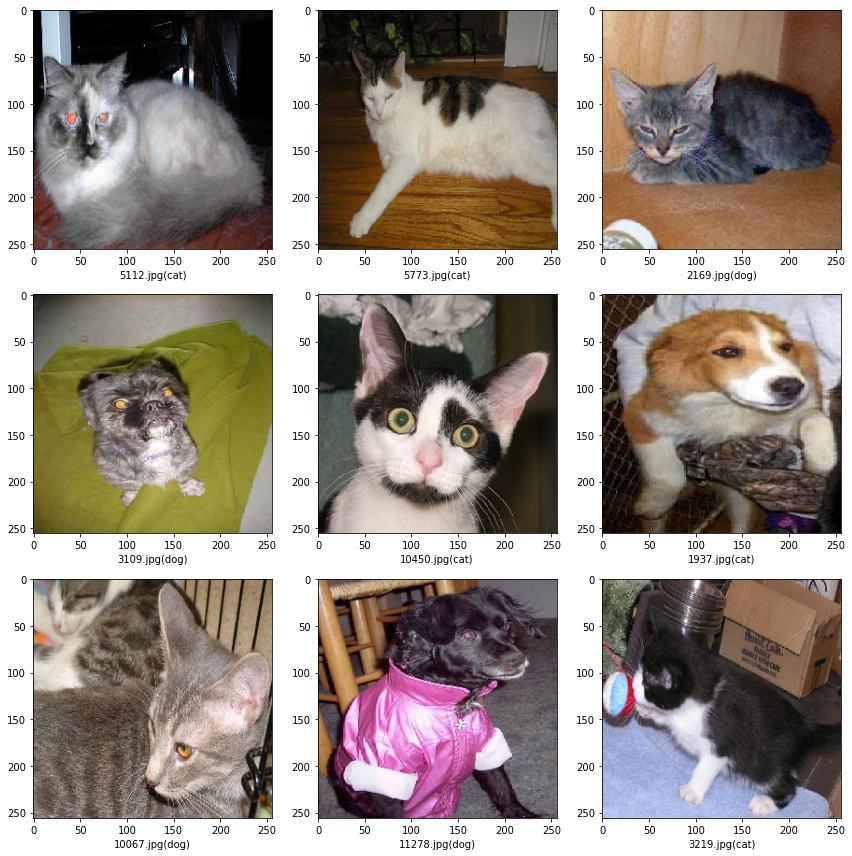

In [35]:
# Mostrando ejemplos de las prediciones
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    pred = "cat" if category < 0.5 else "dog"
    img = load_img("test1/"+filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(pred) + ')')
plt.tight_layout()
plt.show()